次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業の潜在価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [135]:
using StatsPlots
using Random
using Statistics

In [136]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.02, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.01*firms[i].hiddenCorporateValue + 0.99*estimated_value) * exp(0.01*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    lst = []
    marketCap, mean_ln_amp, fundamentals_sum = 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_ln_amp += log(marketCap/fundamentals)
        fundamentals_sum += fundamentals
    end
    mean_ln_amp /= size(firms)[1]
    sort!(lst)
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差額を本チャンの売買リストに加える
    #   すべて仮売り。
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            p = min(firms[i].stockPrice, exp(mean_ln_amp)*agent.fundamentals[i])
            push!(sell, (i, p, q))
        end
    end
    #   仮買い。
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        allocations_lst[i] = agent.portfolio_target[2]*agent.fundamentals[i]/fundamentals_sum
    end
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        p = (exp(mean_ln_amp)*agent.fundamentals[i] + firms[i].marketCapitalization)/(2*firms[i].stockQuantity)
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell, rev=true)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if agent.money - going_to_buy_price < 0.5*agent.portfolio_target[1]
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if price <= 0.0 || quantity == 0.0
            continue
        end
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
            end
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        if rand() < 0.01 - 0.1*agent.performance
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/std(agent.params[3:7])
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function run_one_term(agents, firms, income)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end

run_one_term (generic function with 1 method)

In [137]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0
agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        init_stock_price*init_stock_quantity,
        [],
        [],
    ) for _ = 1:M
];

In [138]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.0

In [139]:
@time for t = 1:1000
    income = 0.0002*init_money
    run_one_term(agents, firms, income)
end

 21.280318 seconds (75.94 M allocations: 1.704 GiB, 8.30% gc time, 13.54% compilation time)


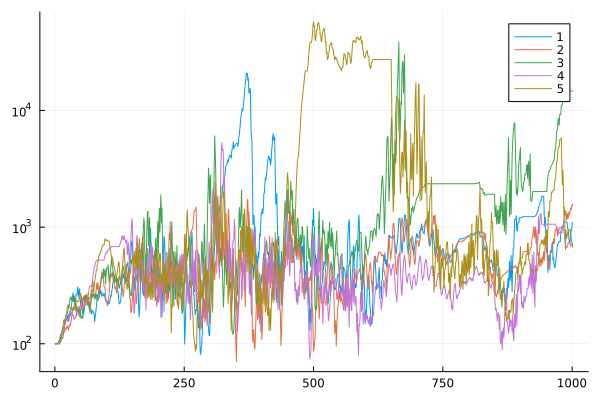

In [140]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

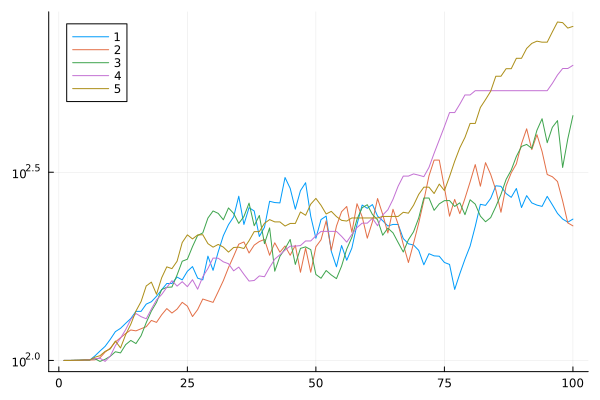

In [141]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

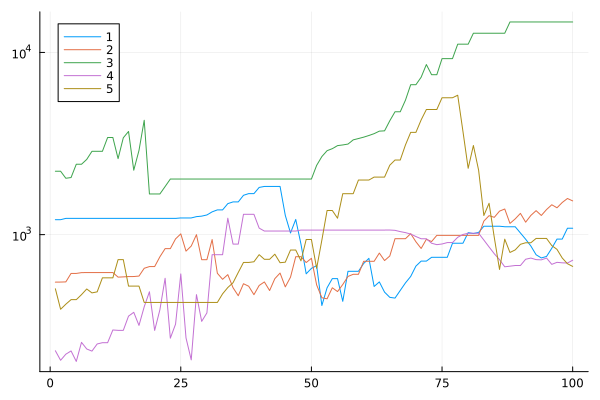

In [142]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(5), yscale=:log10)

In [161]:
firms[3].buy_offers

Any[]

In [146]:
agents

100-element Vector{Agent}:
 Agent("fundamentals", 6371.163043390318, [22.314338682097336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [241.89927046797584, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [100.0, 100.7010925413081, 101.42841611738532, 102.15145816260666, 102.87635081160383, 103.60733908138394, 105.58244471640654, 107.07262640470792, 109.72371797032494, 112.60362994582694  …  6571.48877020057, 6555.197867487704, 6536.113735624105, 6530.458526463725, 6534.772598100367, 6554.371311671936, 6578.630586387554, 6579.792660636831, 6611.93519654634, 6613.044313858294], [0.6555144314168749, 12.0], [68.64048280907474, 105.62741884180224, 392.9542700676717, 66.31710207652803, 65.41458995255499, 108.80678006700047, 136.51143316621884, 154.43464275633826, 112.86334228017526, 155.31296262535713], [4334.945983333418, 2278.0983305248765], [3.955810359422169, 3.4468910722887234, 6.916938106247138, 2.5075306788998235, 54.48105596188021, 8.342177186843061, 8.238627295982427, 7.8497190530785

In [147]:
firms

10-element Vector{Firm}:
 Firm(10.84053056262206, 100.0, [1.0, 1.0, 1.0006973086812763, 1.0010317238092572, 1.0014264208788553, 1.001468731574735, 1.0276720019085621, 1.0590920836564637, 1.0899733976256885, 1.1374442262470719  …  9.43521178547639, 8.657395493473295, 7.752462229766266, 7.4488671007867575, 7.589829617118491, 8.415981843643749, 9.451557792371403, 9.451557792371403, 10.84053056262206, 10.84053056262206], [100.0], 1084.053056262206, 69.8536953876703, Any[], Any[(10.84053056262206, 13.784564148475841, 85), (10.84053056262206, 12.556575904014647, 1), (10.84053056262206, 2.0629639275137386, 22), (10.84053056262206, 1.7986728825990106, 45), (10.84053056262206, 1.3233351574773164, 6), (10.84053056262206, 1.132139049341995, 65), (10.84053056262206, 0.8645216254481728, 56), (10.84053056262206, 0.42943561520896734, 57), (10.84053056262206, 0.25639846310325676, 16), (10.84053056262206, 0.23272640995754024, 26), (10.84053056262206, 0.2202564171049871, 61), (10.84053056262206, 0.21532

In [148]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

79253.13701740655

In [149]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

69.8536953876703
121.49290076658289
345.26324247996786
65.3141299430074
68.92638156691237
111.81466813369032
153.90774440724343
156.45618580587143
141.94945999333112
128.77631706335117


In [150]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

1084.053056262206
1531.5444222409603
14685.884088762376
723.6090005950997
669.248196696277
1830.14729765708
2518.985617709184
3085.933218673366
6806.5507429870595
2700.605249264273


In [151]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[68.64048280907474, 105.62741884180224, 392.9542700676717, 66.31710207652803, 65.41458995255499, 108.80678006700047, 136.51143316621884, 154.43464275633826, 112.86334228017526, 155.31296262535713]
[87.14149198133003, 97.28487651571635, 360.70482367454287, 68.25092393186837, 69.02283485881208, 110.52998524093218, 165.7694089651385, 158.0839595456302, 111.83697128653884, 189.97214087922472]
[79.03766259908501, 92.39619232398225, 397.2740256594575, 74.81564152658208, 70.68301008537671, 112.79100907892646, 129.11889744238488, 157.87391342847724, 115.72219186314977, 188.42036433539593]
[92.22856287693104, 108.75033269402417, 380.22182642393864, 66.57786392563766, 67.56121254036609, 

105.23354095617447, 175.47363788366778, 177.93525406440136, 112.33831741847126, 172.73716408861284]
[84.2227340239569, 107.20738692152344, 305.66404490849993, 65.9048257227014, 62.25275590329947, 120.6967882676428, 158.36907311475122, 159.34922676124114, 111.12389325783607, 151.30045759965157]
[86.90906987489159, 94.53572380056337, 336.54658025457593, 66.72882864535246, 66.17722272610972, 108.79882897463472, 143.56006826529386, 160.7807830948873, 112.36751080654925, 167.2130986848874]
[98.71737975017228, 96.65575392826074, 396.59316023854643, 65.77547453732156, 66.87105847213635, 110.646289483947, 170.54974465807953, 163.60827962127388, 113.48267165013112, 154.55265612619863]
[73.45955624301037, 98.93867546663502, 366.10216965439673, 66.33723683646853, 61.59010218570493, 104.55175705178887, 184.82368596307663, 150.040348409186, 108.71460450852739, 214.989708009123]
[84.94460872000954, 99.80631999044307, 326.4062954849509, 62.33855944360101, 63.47045416045281, 120.60846147958858, 162.36

In [152]:
for agent in agents[1:10]
    println(agent.params)
end

[0.6555144314168749, 12.0]
[0.5692808267881964, 4.0]
[0.8267318123861465, 1.0, -0.6049608999707138, -0.9228383868873099, 1.4626046979575251, 0.5987483129494989, -0.5335537240490004, 0.2858294493785248, 0.09202843551567942, 0.251470323289213, 0.601552427314528, 30.0]
[0.9729811338498241, 37.0]
[0.9621726361982885, 7.0]
[0.9740749945679922, 28.0]
[0.9603154743707984, 23.0]
[0.9989782810849701, 16.0]
[0.9603967247441709, 18.0]
[0.9087494031688208, 45.0]


In [153]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[22.314338682097336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[11.537312255597373, 10.504009380610547, 0.0, 8.637472528113012, 0.0, 18.868275086965294, 0.5677614080392404, 0.0, 11.601692249434585, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2.5483516316181234, 18.302080528873553, 3.97985906440074, 9.612189808513104, 0.0, 1.6722246500072964, 0.5995016156855649, 4.367671822263101, 33.653585600078834, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [154]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
